In [1]:
import nltk
nltk.download("punkt")
import numpy as np
import re
import urllib

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mobasshirbhuia/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
SEED = 1234

In [3]:
# Set seed for reproducibility
np.random.seed(SEED)

In [4]:
# Split text into sentences
tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
book = urllib.request.urlopen(url="https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/datasets/harrypotter.txt")
sentences = tokenizer.tokenize(str(book.read()))
print (f"{len(sentences)} sentences")

12443 sentences


In [5]:
sentences[:5]

["b'Harry Potter and the Deathly Hallows By J. K. Rowling\\r\\n\\r\\nChapter One The Dark Lord Ascending\\r\\nThe two men appeared out of nowhere, a few yards apart in the narrow, moonlit lane.",
 "For a second they stood quite still, wands directed at each other\\'s chests; then, recognizing each other, they stowed their wands beneath their cloaks and started walking briskly in the same direction.",
 '"News?"',
 'asked the taller of the two.',
 '"The best," replied Severus Snape.']

In [6]:
def preprocess(text):
    """Conditional preprocessing on our text."""
    # Lower
    text = text.lower()

    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
    text = re.sub("[^A-Za-z0-9]+", " ", text) # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()

    # Separate into word tokens
    text = text.split(" ")

    return text

In [7]:
# Preprocess sentences
print (sentences[11])
sentences = [preprocess(sentence) for sentence in sentences]
print (sentences[11])

Snape nodded, but did not elaborate.
['snape', 'nodded', 'but', 'did', 'not', 'elaborate']


### Word2Vec

In [8]:
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

In [9]:
EMBEDDING_DIM = 100
WINDOW = 5
MIN_COUNT = 3 # Ignores all words with total frequency lower than this
SKIP_GRAM = 1 # 0 = CBOW
NEGATIVE_SAMPLING = 20

In [11]:
# Super fast because of optimized C code under the hood
w2v = Word2Vec(
    sentences=sentences, vector_size=EMBEDDING_DIM,
    window=WINDOW, min_count=MIN_COUNT,
    sg=SKIP_GRAM, negative=NEGATIVE_SAMPLING)
print (w2v)

Word2Vec(vocab=4937, vector_size=100, alpha=0.025)


In [12]:
# Vector for each word
w2v.wv.get_vector("potter")

array([ 0.21710205,  0.237692  ,  0.0592954 , -0.07985489,  0.09517752,
       -0.28969437,  0.47183746,  0.26759276, -0.3999157 , -0.02191537,
       -0.14402515,  0.03171716, -0.08802347,  0.30826014,  0.12235343,
       -0.03062629,  0.29036772,  0.1026497 , -0.30932784, -0.30340514,
        0.34278795,  0.27602437,  0.4049073 , -0.20330477, -0.16292319,
        0.03444757, -0.4659836 , -0.31702667, -0.22744374, -0.00952164,
       -0.11662934,  0.4538719 ,  0.27198884, -0.45004848, -0.03083939,
        0.28689602, -0.43850502, -0.09756269, -0.10509751, -0.2724514 ,
        0.20651884, -0.02037722, -0.16187604,  0.1485245 ,  0.20171   ,
        0.26071823, -0.3466709 , -0.3055512 , -0.14942464,  0.09217129,
       -0.01269889,  0.0937115 ,  0.03608094, -0.04900232, -0.07322596,
       -0.19003938,  0.20401101,  0.02362426, -0.07051799,  0.0512586 ,
        0.07159985, -0.25800744, -0.03183749,  0.12028711, -0.19699335,
        0.1821521 ,  0.2675212 ,  0.3730585 , -0.39576593, -0.15

In [13]:
# Get nearest neighbors (excluding itself)
w2v.wv.most_similar(positive="scar", topn=5)

[('forehead', 0.9125005006790161),
 ('pain', 0.8974847793579102),
 ('mouth', 0.8922736644744873),
 ('throat', 0.8868098258972168),
 ('prickling', 0.8744701743125916)]

In [14]:
# Saving and loading
w2v.wv.save_word2vec_format("model.bin", binary=True)
w2v = KeyedVectors.load_word2vec_format("model.bin", binary=True)

### FastText

In [15]:
from gensim.models import FastText

In [17]:
# Super fast because of optimized C code under the hood
ft = FastText(sentences=sentences, vector_size=EMBEDDING_DIM,
              window=WINDOW, min_count=MIN_COUNT,
              sg=SKIP_GRAM, negative=NEGATIVE_SAMPLING)
print (ft)

FastText(vocab=4937, vector_size=100, alpha=0.025)


In [23]:
# This word doesn't exist so the word2vec model will error out
w2v.most_similar(positive="scarring", topn=5)

KeyError: "Key 'scarring' not present"

In [20]:
# FastText will use n-grams to embed an OOV word
ft.wv.most_similar(positive="scarring", topn=5)

[('dabbing', 0.9921090602874756),
 ('bulging', 0.9910171627998352),
 ('shuddering', 0.9908440709114075),
 ('piercing', 0.9902076125144958),
 ('swimming', 0.9901530742645264)]

In [21]:
# Save and loading
ft.wv.save("model.bin")
ft = KeyedVectors.load("model.bin")

### Pretrained embeddings

In [25]:
from gensim.scripts.glove2word2vec import glove2word2vec
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from urllib.request import urlopen
from zipfile import ZipFile

In [26]:
# Arguments
EMBEDDING_DIM = 100

In [62]:
def plot_embeddings(words, embeddings, pca_results):
    for word in words:
        index = embeddings.index_to_key.index(word)
        plt.scatter(pca_results[index, 0], pca_results[index, 1])
        plt.annotate(word, xy=(pca_results[index, 0], pca_results[index, 1]))
    plt.show()

In [31]:
# Unzip the file (may take ~3-5 minutes)
resp = urlopen("http://nlp.stanford.edu/data/glove.6B.zip")
zipfile = ZipFile(BytesIO(resp.read()))
zipfile.namelist()

In [37]:
# Write embeddings to file
embeddings_file = "glove.6B.{0}d.txt".format(EMBEDDING_DIM)
zipfile.extract(embeddings_file)

'/Users/mobasshirbhuia/Desktop/MultiCoNER/tutorials/glove.6B.100d.txt'

In [38]:
# Preview of the GloVe embeddings file
with open(embeddings_file, "r") as fp:
    line = next(fp)
    values = line.split()
    word = values[0]
    embedding = np.asarray(values[1:], dtype='float32')
    print (f"word: {word}")
    print (f"embedding:\n{embedding}")
    print (f"embedding dim: {len(embedding)}")

word: the
embedding:
[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459


In [39]:
# Save GloVe embeddings to local directory in word2vec format
word2vec_output_file = "{0}.word2vec".format(embeddings_file)
glove2word2vec(embeddings_file, word2vec_output_file)

/opt/miniconda3/envs/mwml_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  This is separate from the ipykernel package so we can avoid doing imports until


(400000, 100)

In [40]:
# Load embeddings (may take a minute)
glove = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [42]:
# (king - man) + woman = ?
# king - man = ? -  woman
glove.most_similar(positive=["woman", "king"], negative=["man"], topn=5)

[('queen', 0.7698541283607483),
 ('monarch', 0.6843380928039551),
 ('throne', 0.6755736470222473),
 ('daughter', 0.6594555974006653),
 ('princess', 0.6520534157752991)]

In [44]:
# Get nearest neighbors (excluding itself)
glove.most_similar(positive="goku", topn=5)

[('gohan', 0.7246543169021606),
 ('bulma', 0.6497019529342651),
 ('raistlin', 0.644360363483429),
 ('skaar', 0.6316742897033691),
 ('guybrush', 0.6231325268745422)]

In [60]:
# Reduce dimensionality for plotting
X = glove[glove.index_to_key]
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X)

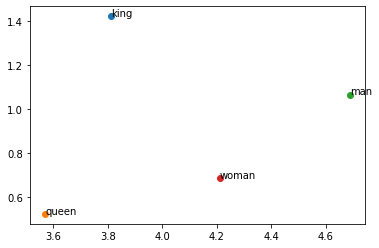

In [63]:
# Visualize
plot_embeddings(
    words=["king", "queen", "man", "woman"], embeddings=glove,
    pca_results=pca_results)

In [64]:
# Bias in embeddings
glove.most_similar(positive=["woman", "doctor"], negative=["man"], topn=5)

[('nurse', 0.7735227942466736),
 ('physician', 0.7189430594444275),
 ('doctors', 0.6824329495429993),
 ('patient', 0.6750682592391968),
 ('dentist', 0.6726033091545105)]

### Set up

In [65]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn

In [66]:
SEED = 1234

In [67]:
def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # multi-GPU

In [68]:
# Set seeds for reproducibility
set_seeds(seed=SEED)

In [69]:
# Set device
cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")
torch.set_default_tensor_type("torch.FloatTensor")
if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
print (device)

cpu


### Load data

In [70]:
# Load data
url = "https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/datasets/news.csv"
df = pd.read_csv(url, header=0) # load
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()

,title,category
0,Sharon Accepts Plan to Reduce Gaza Army Operat...,World
1,Internet Key Battleground in Wildlife Crime Fight,Sci/Tech
2,July Durable Good Orders Rise 1.7 Percent,Business
3,Growing Signs of a Slowing on Wall Street,Business
4,The New Faces of Reality TV,World


### Preprocessing

In [71]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [72]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
print (STOPWORDS[:5])
porter = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mobasshirbhuia/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'me', 'my', 'myself', 'we']


In [73]:
def preprocess(text, stopwords=STOPWORDS):
    """Conditional preprocessing on our text unique to our task."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub("", text)

    # Remove words in paranthesis
    text = re.sub(r"\([^)]*\)", "", text)

    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
    text = re.sub("[^A-Za-z0-9]+", " ", text) # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()

    return text

In [74]:
# Sample
text = "Great week for the NYSE!"
preprocess(text=text)

'great week nyse'

In [75]:
# Apply to dataframe
preprocessed_df = df.copy()
preprocessed_df.title = preprocessed_df.title.apply(preprocess)
print (f"{df.title.values[0]}\n\n{preprocessed_df.title.values[0]}")

Sharon Accepts Plan to Reduce Gaza Army Operation, Haaretz Says

sharon accepts plan reduce gaza army operation haaretz says


### Split data

In [76]:
import collections
from sklearn.model_selection import train_test_split

In [77]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [78]:
def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [79]:
# Data
X = preprocessed_df["title"].values
y = preprocessed_df["category"].values

In [80]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (84000,), y_train: (84000,)
X_val: (18000,), y_val: (18000,)
X_test: (18000,), y_test: (18000,)
Sample point: china battles north korea nuclear talks → World


In [83]:
import itertools
import json

In [84]:
class LabelEncoder(object):
    """Label encoder for tag labels."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {'class_to_index': self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [85]:
# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
NUM_CLASSES = len(label_encoder)
label_encoder.class_to_index

{'Business': 0, 'Sci/Tech': 1, 'Sports': 2, 'World': 3}

In [86]:
# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train = label_encoder.encode(y_train)
y_val = label_encoder.encode(y_val)
y_test = label_encoder.encode(y_test)
print (f"y_train[0]: {y_train[0]}")

y_train[0]: World
y_train[0]: 3


In [87]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")

counts: [21000 21000 21000 21000]
weights: {0: 4.761904761904762e-05, 1: 4.761904761904762e-05, 2: 4.761904761904762e-05, 3: 4.761904761904762e-05}


### Tokenizer

In [89]:
import json
from collections import Counter
from more_itertools import take

In [90]:
class Tokenizer(object):
    def __init__(self, char_level, num_tokens=None,
                 pad_token="<PAD>", oov_token="<UNK>",
                 token_to_index=None):
        self.char_level = char_level
        self.separator = "" if self.char_level else " "
        if num_tokens: num_tokens -= 2 # pad + unk tokens
        self.num_tokens = num_tokens
        self.pad_token = pad_token
        self.oov_token = oov_token
        if not token_to_index:
            token_to_index = {pad_token: 0, oov_token: 1}
        self.token_to_index = token_to_index
        self.index_to_token = {v: k for k, v in self.token_to_index.items()}

    def __len__(self):
        return len(self.token_to_index)

    def __str__(self):
        return f"<Tokenizer(num_tokens={len(self)})>"

    def fit_on_texts(self, texts):
        if not self.char_level:
            texts = [text.split(" ") for text in texts]
        all_tokens = [token for text in texts for token in text]
        counts = Counter(all_tokens).most_common(self.num_tokens)
        self.min_token_freq = counts[-1][1]
        for token, count in counts:
            index = len(self)
            self.token_to_index[token] = index
            self.index_to_token[index] = token
        return self

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            if not self.char_level:
                text = text.split(" ")
            sequence = []
            for token in text:
                sequence.append(self.token_to_index.get(
                    token, self.token_to_index[self.oov_token]))
            sequences.append(np.asarray(sequence))
        return sequences

    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = []
            for index in sequence:
                text.append(self.index_to_token.get(index, self.oov_token))
            texts.append(self.separator.join([token for token in text]))
        return texts

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {
                "char_level": self.char_level,
                "oov_token": self.oov_token,
                "token_to_index": self.token_to_index
            }
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [91]:
# Tokenize
tokenizer = Tokenizer(char_level=False, num_tokens=5000)
tokenizer.fit_on_texts(texts=X_train)
VOCAB_SIZE = len(tokenizer)
print (tokenizer)

<Tokenizer(num_tokens=5000)>


In [92]:
# Sample of tokens
print (take(5, tokenizer.token_to_index.items()))
print (f"least freq token's freq: {tokenizer.min_token_freq}") # use this to adjust num_tokens

[('<PAD>', 0), ('<UNK>', 1), ('39', 2), ('b', 3), ('gt', 4)]
least freq token's freq: 14


In [93]:
# Convert texts to sequences of indices
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)
preprocessed_text = tokenizer.sequences_to_texts([X_train[0]])[0]
print ("Text to indices:\n"
    f"  (preprocessed) → {preprocessed_text}\n"
    f"  (tokenized) → {X_train[0]}")

Text to indices:
  (preprocessed) → china battles north korea nuclear talks
  (tokenized) → [  16 1491  285  142  114   24]


### Embedding layer

In [94]:
# Input
vocab_size = 10
x = torch.randint(high=vocab_size, size=(1,5))
print (x)
print (x.shape)

tensor([[5, 1, 6, 5, 6]])
torch.Size([1, 5])


In [95]:
# Embedding layer
embeddings = nn.Embedding(embedding_dim=100, num_embeddings=vocab_size)
print (embeddings.weight.shape)

torch.Size([10, 100])


In [96]:
# Embed the input
embeddings(x).shape

torch.Size([1, 5, 100])

In [97]:
def pad_sequences(sequences, max_seq_len=0):
    """Pad sequences to max length in sequence."""
    max_seq_len = max(max_seq_len, max(len(sequence) for sequence in sequences))
    padded_sequences = np.zeros((len(sequences), max_seq_len))
    for i, sequence in enumerate(sequences):
        padded_sequences[i][:len(sequence)] = sequence
    return padded_sequences

In [98]:
# 2D sequences
padded = pad_sequences(X_train[0:3])
print (padded.shape)
print (padded)

(3, 6)
[[1.600e+01 1.491e+03 2.850e+02 1.420e+02 1.140e+02 2.400e+01]
 [1.445e+03 2.300e+01 6.560e+02 2.197e+03 1.000e+00 0.000e+00]
 [1.200e+02 1.400e+01 1.955e+03 1.005e+03 1.529e+03 4.014e+03]]


### Dataset

In [99]:
FILTER_SIZES = list(range(1, 4)) # uni, bi and tri grams

In [100]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, max_filter_size):
        self.X = X
        self.y = y
        self.max_filter_size = max_filter_size

    def __len__(self):
        return len(self.y)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return [X, y]

    def collate_fn(self, batch):
        """Processing on a batch."""
        # Get inputs
        batch = np.array(batch)
        X = batch[:, 0]
        y = batch[:, 1]

        # Pad sequences
        X = pad_sequences(X)

        # Cast
        X = torch.LongTensor(X.astype(np.int32))
        y = torch.LongTensor(y.astype(np.int32))

        return X, y

    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        return torch.utils.data.DataLoader(
            dataset=self, batch_size=batch_size, collate_fn=self.collate_fn,
            shuffle=shuffle, drop_last=drop_last, pin_memory=True)

In [101]:
# Create datasets
max_filter_size = max(FILTER_SIZES)
train_dataset = Dataset(X=X_train, y=y_train, max_filter_size=max_filter_size)
val_dataset = Dataset(X=X_val, y=y_val, max_filter_size=max_filter_size)
test_dataset = Dataset(X=X_test, y=y_test, max_filter_size=max_filter_size)
print ("Datasets:\n"
    f"  Train dataset:{train_dataset.__str__()}\n"
    f"  Val dataset: {val_dataset.__str__()}\n"
    f"  Test dataset: {test_dataset.__str__()}\n"
    "Sample point:\n"
    f"  X: {train_dataset[0][0]}\n"
    f"  y: {train_dataset[0][1]}")

Datasets:
  Train dataset:<Dataset(N=84000)>
  Val dataset: <Dataset(N=18000)>
  Test dataset: <Dataset(N=18000)>
Sample point:
  X: [  16 1491  285  142  114   24]
  y: 3


In [102]:
# Create dataloaders
batch_size = 64
train_dataloader = train_dataset.create_dataloader(batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(batch_size=batch_size)
batch_X, batch_y = next(iter(train_dataloader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}\n"
    "Sample point:\n"
    f"  X: {batch_X[0]}\n"
    f"  y: {batch_y[0]}")

Sample batch:
  X: [64, 14]
  y: [64]
Sample point:
  X: tensor([  16, 1491,  285,  142,  114,   24,    0,    0,    0,    0,    0,    0,
           0,    0])
  y: 3


/opt/miniconda3/envs/mwml_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


### Model